In [1]:
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
import random
import dotenv
import omegaconf
import hydra
import logging
import wandb
from datetime import date
import dotenv
import os
import pathlib
from typing import Dict, Any
from copy import deepcopy

from rigl_torch.models import ModelFactory
from rigl_torch.rigl_scheduler import RigLScheduler
from rigl_torch.rigl_constant_fan import RigLConstFanScheduler
from rigl_torch.datasets import get_dataloaders
from rigl_torch.optim import (
    get_optimizer,
    get_lr_scheduler,
)
from rigl_torch.utils.checkpoint import Checkpoint
from rigl_torch.utils.rigl_utils import get_T_end, get_fan_in_after_ablation, get_conv_idx_from_flat_idx
from hydra import initialize, compose



In [14]:
with initialize("../configs", version_base="1.2.0"):
    cfg = compose(
        "config.yaml",
        overrides=[
            "dataset=imagenet",
            "compute.distributed=False",
            "model=resnet50"
            ])
dotenv.load_dotenv("../.env")
os.environ["IMAGE_NET_PATH"]
print(cfg.model.name)

resnet50


In [15]:
run_id = "vchnjrf5" 
rank=0
# checkpoint = Checkpoint.load_last_checkpoint(run_id=run_id, parent_dir = cfg.paths.checkpoints
checkpoint=None
if checkpoint is not None:
    run_id = checkpoint.run_id
    optimizer_state = checkpoint.optimizer
    scheduler_state = checkpoint.scheduler
    pruner_state = checkpoint.pruner
    model_state = checkpoint.model
    cfg = checkpoint.cfg
else:
    run_id, optimizer_state, scheduler_state, pruner_state, model_state = (
        None,
        None,
        None,
        None,
        None,
    )


    # cfg.compute.distributed=False
    
pl.seed_everything(cfg.training.seed)
use_cuda = not cfg.compute.no_cuda and torch.cuda.is_available()
if not use_cuda:
    raise SystemError("GPU has stopped responding...waiting to die!")
    logger.warning(
        "Using CPU! Verify cfg.compute.no_cuda and "
        "torch.cuda.is_available() are properly set if this is unexpected"
    )

if cfg.compute.distributed:
    device = torch.device(f"cuda:{rank}")
else:
    device = torch.device("cuda" if use_cuda else "cpu")
# train_loader, test_loader = get_dataloaders(cfg)

model = ModelFactory.load_model(
    model=cfg.model.name, dataset=cfg.dataset.name
)
model.to(device)
if cfg.compute.distributed:
    model = DistributedDataParallel(model, device_ids=[rank])
if model_state is not None:
    try:
        model.load_state_dict(model_state)
    except RuntimeError:
        model_state = checkpoint.get_single_process_model_state_from_distributed_state()
        model.load_state_dict(model_state)
        
optimizer = get_optimizer(cfg, model, state_dict=optimizer_state)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=scheduler_state)
pruner = None
if cfg.rigl.dense_allocation is not None:
    T_end = get_T_end(cfg, [0 for _ in range(0,1251)])
    if cfg.rigl.const_fan_in:
        rigl_scheduler = RigLConstFanScheduler
    else:
        rigl_scheduler = RigLScheduler
    pruner = rigl_scheduler(
        model,
        optimizer,
        dense_allocation=cfg.rigl.dense_allocation,
        alpha=cfg.rigl.alpha,
        delta=cfg.rigl.delta,
        static_topo=cfg.rigl.static_topo,
        T_end=T_end,
        ignore_linear_layers=cfg.rigl.ignore_linear_layers,
        grad_accumulation_n=cfg.rigl.grad_accumulation_n,
        sparsity_distribution=cfg.rigl.sparsity_distribution,
        erk_power_scale=cfg.rigl.erk_power_scale,
        state_dict=pruner_state,
        filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
        static_ablation=cfg.rigl.static_ablation,
        dynamic_ablation=cfg.rigl.dynamic_ablation,
        min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,  # noqa
        use_sparse_init=cfg.rigl.use_sparse_initialization,
        init_method_str=cfg.rigl.init_method_str,
        use_sparse_const_fan_in_for_ablation=cfg.rigl.use_sparse_const_fan_in_for_ablation,  # noqa
    )

Global seed set to 42
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7f0a9cbb28b0> with args: () and kwargs: {}


In [16]:
scheduler.__dict__

{'step_size': [150, 350, 450],
 'warm_up_steps': 25,
 'gamma': 0.1,
 'lr': 0.4,
 '_linear_warmup_lrs': array([1.00000000e-06, 1.66676250e-02, 3.33342500e-02, 5.00008750e-02,
        6.66675000e-02, 8.33341250e-02, 1.00000750e-01, 1.16667375e-01,
        1.33334000e-01, 1.50000625e-01, 1.66667250e-01, 1.83333875e-01,
        2.00000500e-01, 2.16667125e-01, 2.33333750e-01, 2.50000375e-01,
        2.66667000e-01, 2.83333625e-01, 3.00000250e-01, 3.16666875e-01,
        3.33333500e-01, 3.50000125e-01, 3.66666750e-01, 3.83333375e-01,
        4.00000000e-01]),
 '_logger': <Logger /home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py (INFO)>,
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     foreach: None
     initial_lr: 0.4
     lr: 1e-06
     maximize: False
     momentum: 0.9
     nesterov: True
     weight_decay: 0.0001
 ),
 'base_lrs': [0.4],
 'last_epoch': 0,
 '_step_count': 1,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_lr': 

In [10]:
cfg.training.step_size

[150, 350, 450]

/home/user/build/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:124: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.04000000000000001 @ epoch 150
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.004000000000000001 @ epoch 350
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.00040000000000000013 @ epoch 450


[[0.016667625000000002], [0.03333425], [0.050000875], [0.0666675], [0.08333412500000001], [0.10000075], [0.116667375], [0.133334], [0.150000625], [0.16666725000000002], [0.183333875], [0.2000005], [0.21666712500000002], [0.23333375], [0.250000375], [0.266667], [0.283333625], [0.30000024999999997], [0.316666875], [0.3333335], [0.350000125], [0.36666675], [0.383333375], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4],

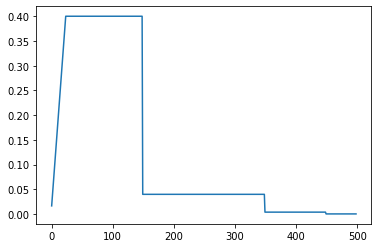

In [17]:
import matplotlib.pyplot as plt

lrs = []
for epoch in list(range(1,500)):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())
print(lrs)
plt.plot(lrs)

In [5]:
pruner.__str__()

'RigLScheduler(\nlayers=54,\nnonzero_params=[384/9408, 576/4096, 640/36864, 1536/16384, 1536/16384, 1536/16384, 640/36864, 1536/16384, 1536/16384, 640/36864, 1536/16384, 1792/32768, 1152/147456, 3072/65536, 3584/131072, 3072/65536, 1152/147456, 3072/65536, 3072/65536, 1152/147456, 3072/65536, 3072/65536, 1152/147456, 3072/65536, 3584/131072, 2304/589824, 6144/262144, 7168/524288, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 7168/524288, 4608/2359296, 12288/1048576, 14336/2097152, 12288/1048576, 4608/2359296, 12288/1048576, 12288/1048576, 4608/2359296, 12288/1048576, 14000/2048000],\nnonzero_percentages=[4.08%, 14.06%, 1.74%, 9.38%, 9.38%, 9.38%, 1.74%, 9.38%, 9.38%, 1.74%, 9.38%, 5.47%, 0.78%, 4.69%, 2.73%, 4.69%, 0.78%, 4.69%, 4.69%, 0.78%, 4.69%, 4.69%, 0.78%, 4.69%, 2.73%, 0.39%, 2.34%, 1.37%, 2.34%, 0.39%, 2.34%, 2.34%, 0.39%, 2.34%, 

In [18]:
# net = ModelFactory.load_model("wide_resnet22", "cifar10")
model = ModelFactory.load_model("resnet50", "imagenet")
device = torch.device("cuda:0")
train_loader, test_loader = get_dataloaders(cfg)
# model = ModelFactory.load_model(
#         model=cfg.model.name, dataset=cfg.dataset.name
#     )
model.to(device)
optimizer = get_optimizer(cfg, model, state_dict=None)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=None)
T_end = get_T_end(cfg, train_loader)
if cfg.rigl.const_fan_in:
    rigl_scheduler = RigLConstFanScheduler
else:
    rigl_scheduler = RigLScheduler
# pruner = rigl_scheduler(
#     model,
#     optimizer,
#     dense_allocation=cfg.rigl.dense_allocation,
#     alpha=cfg.rigl.alpha,
#     delta=cfg.rigl.delta,
#     static_topo=cfg.rigl.static_topo,
#     T_end=T_end,
#     ignore_linear_layers=False,
#     grad_accumulation_n=cfg.rigl.grad_accumulation_n,
#     sparsity_distribution=cfg.rigl.sparsity_distribution,
#     erk_power_scale=cfg.rigl.erk_power_scale,
#     state_dict=None,
#     filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
#     static_ablation=cfg.rigl.static_ablation,
#     dynamic_ablation=cfg.rigl.dynamic_ablation,
#     min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,
#     )

INFO:/project/6066928/mklasby/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7f808c85ac10> with args: () and kwargs: {}


Files already downloaded and verified


In [ ]:
pruner(
    
)